<img src = "https://github.com/singlestore-labs/spaces-notebooks/blob/e551e274bb67bb1e5081131ee1150cdba713fc43/common/images/singlestore-jupyter.png?raw=true">

<div id="singlestore-header" style="display: flex; background-color: rgba(235, 249, 245, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/browser.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">FinBERT</h1>
    </div>
</div>

**TL;DR**</br>
This code loads a dataset, preprocesses it for BERT model input, splits it into train, validation, and test sets, trains a BERT model, evaluates it on test data, and plots its performance metrics via confusion matrix, ROC, and precision-recall curves.

**Summary**</br>
The code loads a dataset from a SingleStore database and encodes the labels. Text data are tokenized using a pre-trained BERT tokenizer, and the dataset is split into training, validation, and test sets. Data loaders are created for efficient processing. A pre-trained BERT model for sequence classification is loaded, and the model is trained using a training loop over several epochs. After training, the model is evaluated on a test set, and various metrics such as accuracy, precision, recall, F1-score, and ROC-AUC are calculated. Additionally, a second training loop with attention masks is conducted, followed by evaluation on the validation set. Finally, the code plots a confusion matrix, ROC curve, and precision-recall curve for the test data, providing visualisations of the model's performance.

In [8]:
!pip cache purge --quiet

In [9]:
!pip install transformers==4.27.2 --quiet
!pip install scikit-learn --quiet
!pip install torch==1.13.1 --quiet
!pip install matplotlib --quiet

In [6]:
# Import Libraries
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import time
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Action Required</b></p>
        <p>Select the database from the drop-down menu at the top of this notebook. It updates the <b>connection_url</b> which is used by SQLAlchemy to make connections to the selected database.</p>
    </div>
</div>

In [8]:
from sqlalchemy import *

db_connection = create_engine(connection_url)

In [9]:
dataset = pd.read_sql(
    "SELECT Fraud, Filings FROM financial_filings",
    con = db_connection
)

In [10]:
import warnings

warnings.filterwarnings("ignore", category = FutureWarning)

# Encode Labels
label_encoder = LabelEncoder()
dataset["Fraud"] = label_encoder.fit_transform(dataset["Fraud"])

# Tokenize the Text Data
tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-pretrain")
text_data = dataset["Filings"].tolist()
max_length = 512
encoded_inputs = tokenizer(text_data, padding = True, truncation = True, max_length = max_length, return_tensors = "pt")
attention_masks = encoded_inputs["attention_mask"]

print(tokenizer)

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/359 [00:00<?, ?B/s]

BertTokenizer(name_or_path='yiyanghkust/finbert-pretrain', vocab_size=30873, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


In [21]:
# Split the Dataset into Training, Validation, and Test Sets
train_inputs, temp_inputs, train_labels, temp_labels, train_masks, temp_masks = train_test_split(
    encoded_inputs["input_ids"], dataset["Fraud"], attention_masks, test_size = 0.4, random_state = 42
)

val_inputs, test_inputs, val_labels, test_labels, val_masks, test_masks = train_test_split(
    temp_inputs, temp_labels, temp_masks, test_size = 0.5, random_state = 42
)

In [24]:
# Create DataLoader with attention masks
train_dataset = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels.values).long())
train_dataloader = DataLoader(train_dataset, batch_size = 4, shuffle = True)

val_dataset = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels.values).long())
val_dataloader = DataLoader(val_dataset, batch_size = 4)

test_dataset = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels.values).long())
test_dataloader = DataLoader(test_dataset, batch_size = 4)

# Load Pre-trained BERT Model for Sequence Classification
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-pretrain', num_labels = 2)
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-5)

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at yiyanghkust/finbert-pretrain were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [26]:
# Training Loop
model.train()
start_time = time.time() # track start time
for epoch in range(3):
    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask = masks, labels = labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        end_time = time.time() #track end time
        epoch_time = end_time - start_time # Time taken to train the model

    print(f"Time taken for epoch {epoch+1}: {epoch_time:.2f} seconds")

total_end_time = time.time()
total_time = total_end_time - start_time

print(f"Total training time: {total_time:.2f} seconds")

Time taken for epoch 1: 290.62 seconds
Time taken for epoch 2: 581.52 seconds
Time taken for epoch 3: 868.63 seconds
Total training time: 868.63 seconds


In [39]:
# Evaluation
model.eval()
test_predictions = []
test_true_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        inputs, masks, labels = batch
        outputs = model(inputs, attention_mask = masks)
        logits = outputs.logits
        predictions = torch.argmax(F.softmax(logits, dim = 1), dim = 1)
        test_predictions.extend(predictions.tolist())
        test_true_labels.extend(labels.tolist())

In [40]:
# Metrics for Test Set
accuracy = accuracy_score(test_true_labels, test_predictions)
precision = precision_score(test_true_labels, test_predictions)
recall = recall_score(test_true_labels, test_predictions)
f1 = f1_score(test_true_labels, test_predictions)
roc_auc = roc_auc_score(test_true_labels, test_predictions)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1-score:", f1)
print("Test ROC-AUC:", roc_auc)

Test Accuracy: 0.47058823529411764
Test Precision: 1.0
Test Recall: 0.1
Test F1-score: 0.18181818181818182
Test ROC-AUC: 0.55


In [41]:
# Training Loop with attention masks
num_epochs = 4
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_predictions = []
    train_true_labels = []
    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask = masks, labels = labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        logits = outputs.logits
        predictions = torch.argmax(F.softmax(logits, dim = 1), dim = 1)
        train_predictions.extend(predictions.tolist())
        train_true_labels.extend(labels.tolist())

    # Training Metrics
    train_accuracy = accuracy_score(train_true_labels, train_predictions)
    train_precision = precision_score(train_true_labels, train_predictions)
    train_recall = recall_score(train_true_labels, train_predictions)
    train_f1 = f1_score(train_true_labels, train_predictions)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {train_loss/len(train_dataloader)}")
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Training Precision: {train_precision}")
    print(f"Training Recall: {train_recall}")
    print(f"Training F1-score: {train_f1}")

    # Validation Loop
    model.eval()
    val_predictions = []
    val_true_labels = []
    with torch.no_grad():
        for batch in val_dataloader:
            inputs, masks, labels = batch
            outputs = model(inputs, attention_mask = masks)
            logits = outputs.logits
            predictions = torch.argmax(F.softmax(logits, dim = 1), dim = 1)
            val_predictions.extend(predictions.tolist())
            val_true_labels.extend(labels.tolist())

    # Validation Metrics
    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    val_precision = precision_score(val_true_labels, val_predictions)
    val_recall = recall_score(val_true_labels, val_predictions)
    val_f1 = f1_score(val_true_labels, val_predictions)

    print(f"Validation Accuracy: {val_accuracy}")
    print(f"Validation Precision: {val_precision}")
    print(f"Validation Recall: {val_recall}")
    print(f"Validation F1-score: {val_f1}\n")

Epoch 1/4
Training Loss: 0.36519447957667023
Training Accuracy: 0.8333333333333334
Training Precision: 0.8571428571428571
Training Recall: 0.8076923076923077
Training F1-score: 0.8316831683168316
Validation Accuracy: 0.7647058823529411
Validation Precision: 0.6470588235294118
Validation Recall: 0.8461538461538461
Validation F1-score: 0.7333333333333333

Epoch 2/4
Training Loss: 0.074263752438128
Training Accuracy: 0.9705882352941176
Training Precision: 0.9803921568627451
Training Recall: 0.9615384615384616
Training F1-score: 0.970873786407767
Validation Accuracy: 0.7058823529411765
Validation Precision: 0.5789473684210527
Validation Recall: 0.8461538461538461
Validation F1-score: 0.6875

Epoch 3/4
Training Loss: 0.022847276324262984
Training Accuracy: 0.9901960784313726
Training Precision: 0.9811320754716981
Training Recall: 1.0
Training F1-score: 0.9904761904761905
Validation Accuracy: 0.6470588235294118
Validation Precision: 0.5217391304347826
Validation Recall: 0.9230769230769231
Va

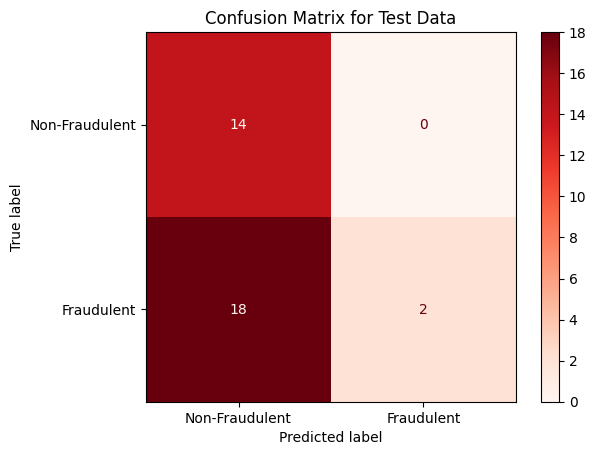

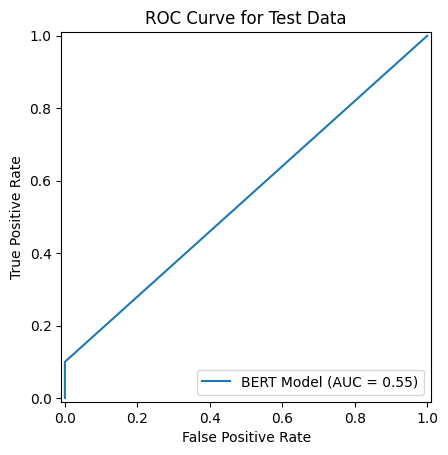

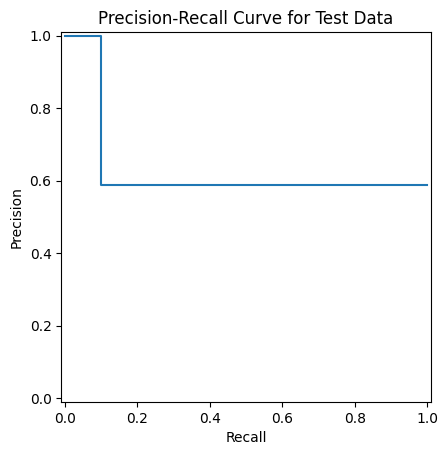

In [58]:
#1. Plot the Confusion Matrix
cm = confusion_matrix(test_true_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Non-Fraudulent", "Fraudulent"])
disp.plot(cmap = plt.cm.Reds)
plt.title("Confusion Matrix for Test Data")
plt.show()

# 2. Plot the ROC Curve
fpr, tpr, _ = roc_curve(test_true_labels, test_predictions)
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = "BERT Model")
roc_display.plot()
plt.title("ROC Curve for Test Data")
plt.show()

# 3. Plot the Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(test_true_labels, test_predictions)
pr_display = PrecisionRecallDisplay(precision = precision_curve, recall = recall_curve)
pr_display.plot()
plt.title("Precision-Recall Curve for Test Data")
plt.show()

[Financial-Fraud-Detection-Using-LLMs](https://github.com/amitkedia007/Financial-Fraud-Detection-Using-LLMs)

## MIT License

Copyright (c) 2023 Amit Kedia

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.